In [5]:
import math
import numpy as numpy
import matplotlib.pyplot as plt
%matplotlib inline

##### Graphviz

In [25]:
!pip install graphviz
from graphviz import Digraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 916.3 kB/s eta 0:00:00 0:00:01


In [70]:
def trace(root):
    # build set of all nodes and edges
    nodes, edges = set(), set()

    def build(node):
        # node is not in nodes add it to the list
        if node not in nodes:
            nodes.add(node)

        # for each child of node
        # add an edge from node to child
        # in our case it would be children
        # that is connect all prev to node
        for child in node._prev:
            edges.add((child, node))
            # now recursively call build on each child
            build(child)

    # start building from the root
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR => Left to right

    nodes, edges = trace(root=root)

    for node in nodes:
        # unique id for the node
        uid = str(id(node))

        # for values we create a rectangular shape i.e. record
        dot.node(name = uid, label = "{ %s | data %.4f }" % (node._label, node.data), shape='record')

        # there is a node with operation
        if node._op:
            # i.e, if this is a result of some operation
            dot.node(name = uid + node._op, label = node._op)

            # connect node to it
            dot.edge(uid + node._op, uid)
        
    for n1, n2 in edges:
        # connect node 1 to the op node of node 2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot


##### Value Class

In [74]:
class Value:

    def __init__(self, data, _children=(), _op='', _label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self._label = _label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        return Value(self.data + other.data, _children=(self, other), _op='+')

    def __mul__(self, other):
        return Value(self.data * other.data, _children=(self, other), _op='*')


In [80]:
a = Value(2.0, _label='a')
b = Value(-3.0, _label='b')
c = Value(10.0, _label='c')
e = a * b; e._label = 'e'
d = e + c; d._label = 'd'
f = Value(-2.0, _label='f')
L = d * f; L._label='L'
L

Value(data=-8.0)

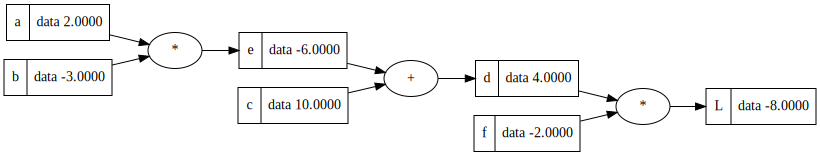

In [81]:
draw_dot(L)